<a href="https://colab.research.google.com/github/Barryjuait/Barryjuait/blob/master/Dysk_applyModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from __future__ import print_function
import os
import sys
import pandas as pd
import numpy as np
import random
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import datetime

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Activation, Dense, Input, Dropout, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, Flatten, AveragePooling1D, LeakyReLU, BatchNormalization, UpSampling1D, Reshape
from keras.optimizers import SGD
from keras.models import Model, Sequential, load_model
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical

import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, StratifiedKFold, StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc

from scipy import signal
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d, gaussian_filter

import librosa

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [4]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
#set current working directory
path = '/content/drive/MyDrive/Colab Notebooks/'
os.chdir(path)
model_path = path + 'models/';

In [9]:
#Read the dataset into a pandas.DataFrame
Data = pd.read_csv(path + 'CollectedSpectra.csv');

In [12]:
#Read result of the last model:
edf = pd.read_csv(model_path +'edf.csv');

In [16]:
# Get the index of the epoch with the lowest validation loss
min_loss_index = np.argmin(edf.LossVal);
best_val_loss = edf.LossVal[min_loss_index];
best_epoch = edf.Epoch[min_loss_index] + 1;
print(f'Best Validation Loss: {best_val_loss:.4f} at epoch {best_epoch}');

Best Validation Loss: 0.0431 at epoch 29


In [17]:
best_model = load_model(os.path.join(model_path, f'dysk.{best_epoch:02d}-{best_val_loss:.4f}.hdf5'));


### Apply the model to the rest of the data:

In [18]:
#Scale the data and update the dataframe:
faxis = np.arange(0, 150.5, 0.5);
scaler = MinMaxScaler();
dummy = Data.iloc[:, range(len(faxis))];
result = scaler.fit_transform(dummy.T)
Data.iloc[:, range(len(faxis))] = result.T;

In [19]:
#Get a copy from the original:
dfx = Data.copy();
dfx.dropna(subset=['Session'], axis=0, inplace=True);
dfx.reset_index(drop=True, inplace=True);
Acc = dfx.Acc;
Hemi = dfx.Hemi;
AIMS = dfx.AIMS;
Drug = dfx.Drug.astype(int);
Session = dfx.Session;
taxis = dfx.taxis;
State = dfx.State;
State[State == 4] = None; #This state will not be counted
State[State == -1] = None; #Noise state will be set as 4

###Plot an example:

In [20]:
faxis = np.arange(0, 150.5, 0.5);
Xx = np.array(dfx.iloc[:, range(len(faxis))]);

# Get the predicted probabilities
originalStates = State.astype('category');

#Choose a random session:
bSessions = np.unique(Session);
idx = random.randint(0,len(bSessions));

#Take its spectrogram:
sel = np.logical_and(Session == bSessions[idx], Hemi == 2);
dummy = Xx[sel,:];

#Predict states with the best model:
pred_probs = best_model.predict(dummy);
predStates = np.argmax(pred_probs, axis = 1);

109/109 [==============================] - 5s 40ms/step


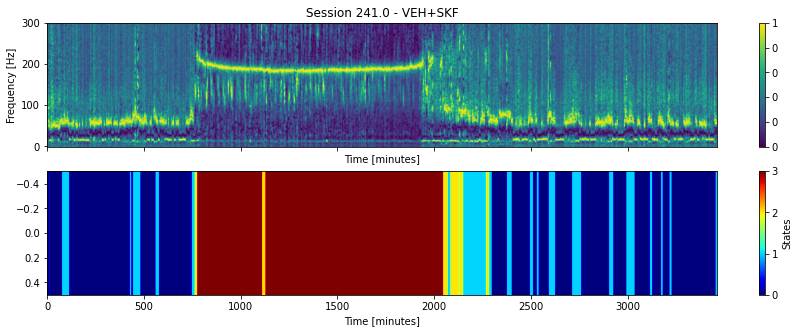

In [21]:
#plot spectrogram + states:

spg = Xx[sel,:].T;
btaxis = np.array(taxis[sel]);
bOrStates = np.array(originalStates[sel]);
bPredStates = np.array(predStates);
bDrugs = ['VEH+LDOPA', 'VEH+SKF', 'VEH+SUM', 'VEH+VEH'];

fig, ax = plt.subplots(2,1, figsize = (15,5), sharex = True)
pcm = ax[0].imshow(spg, aspect = 'auto');
ax[0].invert_yaxis();
fig.colorbar(pcm, ax=ax[0], format='%1i', pad = 0.05)
#ax[0].set_xticks(range(spg.shape[1]));
#ax[0].set_xticklabels(btaxis);
#ax[0].set_yticks(range(spg.shape[0]));
#ax[0].set_yticklabels(faxis);
ax[0].set_xlabel('Time [minutes]');
ax[0].set_ylabel('Frequency [Hz]');
ax[0].set_title(f'Session {bSessions[idx]} - {bDrugs[np.unique(Drug[sel])[0]-1]}');

plotStates = bPredStates.reshape((1, bPredStates.shape[0]));
plotStates2 = pd.Series(bPredStates);
plotStates2 = np.round(np.array(plotStates2.rolling(20, min_periods = 1).mean()));
plotStates2 = plotStates2.reshape((1, plotStates2.shape[0]));

pcm = ax[1].imshow(plotStates2, aspect = 'auto', cmap = 'jet');
cbar = fig.colorbar(pcm, ax=ax[1], ticks = [0, 1, 2, 3], 
                    spacing='proportional', format='%1i', label = 'States', pad = 0.05)
ax[1].set_xlabel('Time [minutes]');
plt.show();

## Collect the predicted states, smooth them, and detect the switches:


In [22]:
#detect states switches:
def get_switches(x, y):
  xdf = pd.DataFrame()
  prev_val = y[0]
  prev_idx = 0
  prev_dur = 0
  for idx, val in enumerate(y):
    if idx >= len(y)-1:
      continue
    if val != prev_val:
        curr_dur = x[idx] - x[prev_idx]
        xdf = xdf.append({'Index': idx,
                          'SwitchTime': x[idx]*60, #in seconds
                        'Before': prev_val,
                        'After': val,
                        'Duration Before': prev_dur,
                        'Duration After': curr_dur},
                        ignore_index=True)
        prev_val = val
        prev_idx = idx
        prev_dur = curr_dur
  curr_dur = x[-1] - x[prev_idx];
  xdf = xdf.append({'Index': len(y),
                  'SwitchTime': x[-1]*60, #in seconds
                  'Before': prev_val,
                  'After': None,
                  'Duration Before': prev_dur,
                  'Duration After': curr_dur},
                  ignore_index=True)
  return xdf


def getDuration(time, vector):
  current_num = None;
  current_duration = 0;
  blocks = [];

  for i, num in enumerate(vector):
      if num == current_num:
          current_duration += 1
      else:
          if current_num is not None:
              onset = i - current_duration
              offset = i - 1
              bDuration = time(offset) - time(onset);
              blocks.append((current_num, time(onset), time(offset), bDuration))
          current_num = num
          current_duration = 1

  # add the final block
  onset = len(vector) - current_duration
  offset = len(vector) - 1
  blocks.append((current_num, onset, offset, current_duration))

  # create a pandas dataframe from the blocks list
  df = pd.DataFrame(blocks, columns=['num', 'onset', 'offset', 'duration'])
  df['block_id'] = range(len(df))

  return df





In [23]:
#Collect the predicted states, smooth them, and detect the switches:
xdf = pd.DataFrame(columns = ['Index', 'SwitchTime', 'Before', 'After', 'Duration Before', 
                              'Duration After', 'Session', 'Drug']);

for k in range(len(bSessions)):
  sel = np.logical_and(Session == bSessions[k], Hemi == 2);
  if sum(sel) == 0:
    continue
  dummy = Xx[sel,:];
  btaxis = np.array(taxis[sel]);

  pred_probs = best_model.predict(dummy);
  predStates = np.argmax(pred_probs, axis = 1);
  bPredStates = np.array(predStates);
  
  bx = pd.Series(bPredStates);
  bx = np.round(np.array(bx.rolling(20, min_periods = 1).mean()));

  bSwitches = get_switches(btaxis, bx);
  bSwitches['Session'] = np.repeat(bSessions[k],len(bSwitches));
  bSwitches['Drug'] = np.repeat(bDrugs[np.unique(Drug[sel])[0]-1],len(bSwitches));
  xdf = pd.concat([xdf, bSwitches], axis = 0, ignore_index = True);
  
#Save to folder:
outputFolder = path + 'switches/';  
os.makedirs(outputFolder, exist_ok=True)  
xdf.to_csv(outputFolder + 'StateSwitches.csv');


109/109 [==============================] - 3s 28ms/step
